In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch import nn
from torch import optim
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader,TensorDataset,SubsetRandomSampler
from sklearn.metrics import balanced_accuracy_score,f1_score
import scanpy as sc
import anndata
import seaborn as sns
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white') 

In [24]:
humdata = np.load('5 x_hum_0902_anno_nn.npz', allow_pickle=True)
humnmf = pd.read_pickle('6 Ws_hum_0902')
x_hum = torch.from_numpy(humnmf[11]).float()
y_hum = torch.from_numpy(humdata['y'].astype(np.int32))
y_hum = y_hum.long() - 1

dataset = TensorDataset(x_hum, y_hum)

inputSize = x_hum.shape[1]
outputSize = 14

device = "cuda:0"
torch.manual_seed(42)
batch_size = x_hum.shape[0]
loss_fn = nn.CrossEntropyLoss()
data_loader = DataLoader(dataset, batch_size=batch_size)

class MLR(nn.Module):
    def __init__(self):
        super(MLR, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(inputSize, outputSize)
        )
            
    def forward(self, x):
        out = self.layers(x)
        if not self.training:
            #print("TESTING MODE")
            out = F.softmax(out, dim=1)
        #out = out.view(out.shape[0], -1)
        return out

In [21]:
class OutputHook(list):
    """ Hook to capture module outputs.
    """
    def __call__(self, module, input, output):
        self.append(output)
        
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.relu = nn.ReLU()
        self.layers = nn.Sequential(
            nn.Linear(inputSize, hiddenSize),
            nn.Dropout(0.5),
            nn.Linear(hiddenSize, outputSize),
            self.relu
        )
            
    def forward(self, x):
        out = self.layers(x)
        if not self.training:
            #print("TESTING MODE")
            out = F.softmax(out, dim=1)
        #out = out.view(out.shape[0], -1)
        return out

In [22]:
def val(model, device, dataloader, loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()

    for inputs, labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        output = model(inputs)

        loss = loss_fn(output,labels)
        valid_loss += loss.item()*inputs.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct += (predictions == labels).sum().item()
        ba_score_ = balanced_accuracy_score(y_hum.cpu(), predictions.cpu())
        f1_score_ = f1_score(y_hum.cpu(), predictions.cpu(),average=None)

    return valid_loss,val_correct,ba_score_,f1_score_

/home/lh3n19/.conda/envs/my/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/lh3n19/.conda/envs/my/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


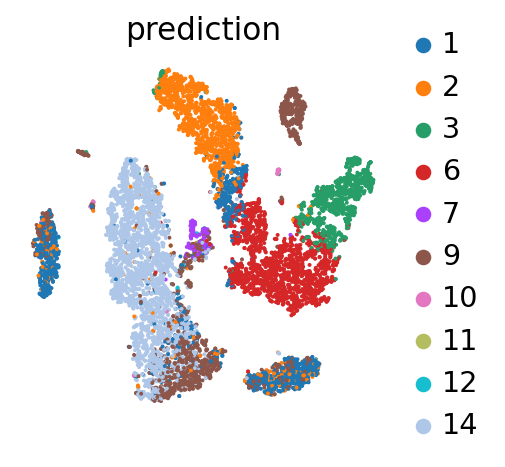

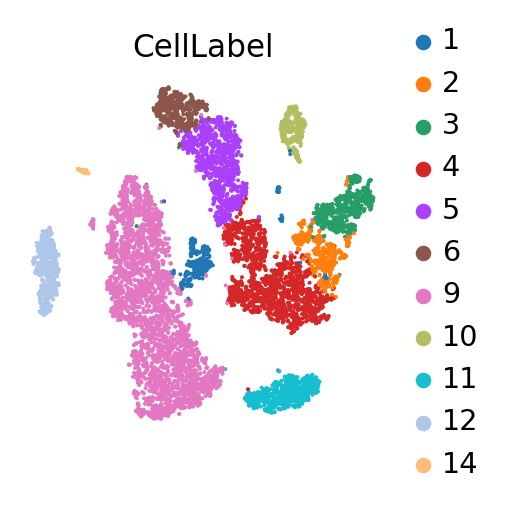

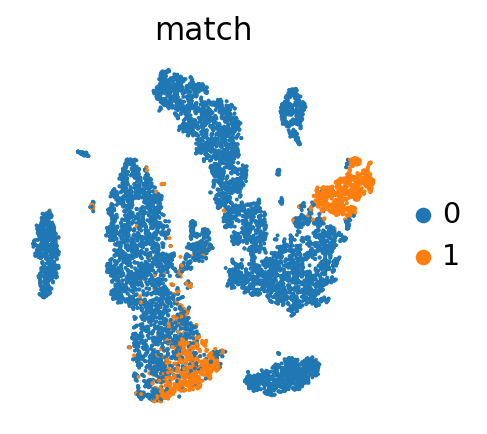

In [15]:
ann = torch.load('ANN_NMF_0902_r10.pt')
ann.to(device)
val(ann, device, data_loader, loss_fn)
v,p = torch.max(ann(x_hum.to(device)),1)
hum_adata = sc.read_h5ad('../2/3 clustered_hum_0831_anno.h5ad')
hum_adata.obs['prediction'] = p.cpu().detach().numpy() + 1
hum_adata.obs = hum_adata.obs.astype({'prediction': 'category'})
hum_adata.obs['match'] = ((hum_adata.obs['prediction'].astype('int64') == hum_adata.obs['CellLabel'].astype('int64'))*1).astype('category')
sc.pl.tsne(hum_adata,color='prediction')
sc.pl.tsne(hum_adata,color='CellLabel')
sc.pl.tsne(hum_adata,color='match')

/home/lh3n19/.conda/envs/my/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(24339.85149049759, 2584, 0.1503429691023047, array([0.00362976, 0.        , 0.84663428, 0.0147108 , 0.13251156,
       0.        , 0.        , 0.        , 0.61714097, 0.        ,
       0.        , 0.        , 0.        , 0.        ]))


/home/lh3n19/.conda/envs/my/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


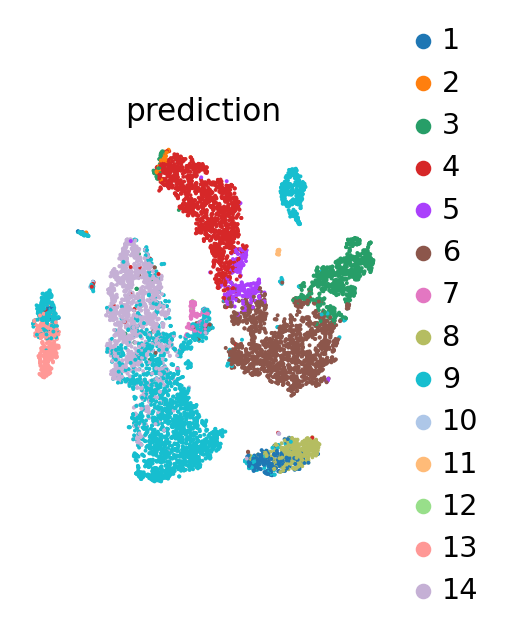

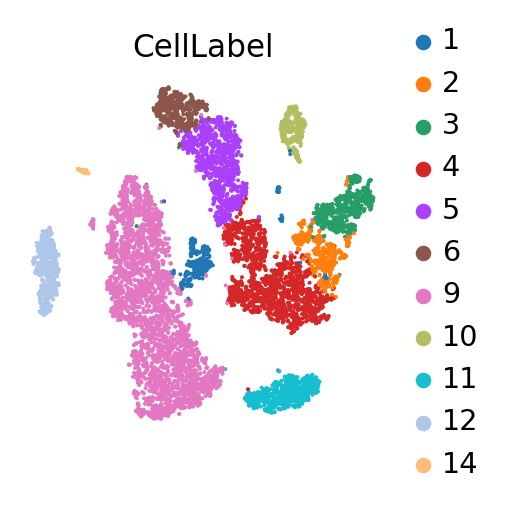

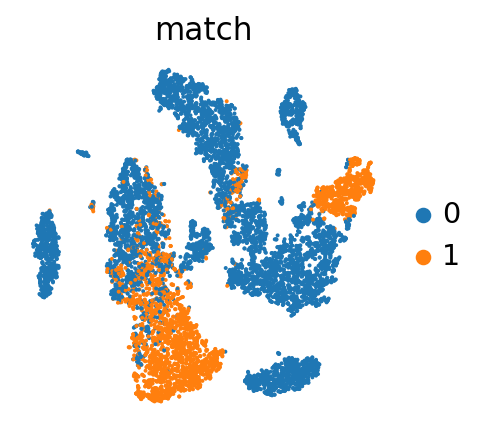

<AxesSubplot:xlabel='CellLabel', ylabel='prediction'>

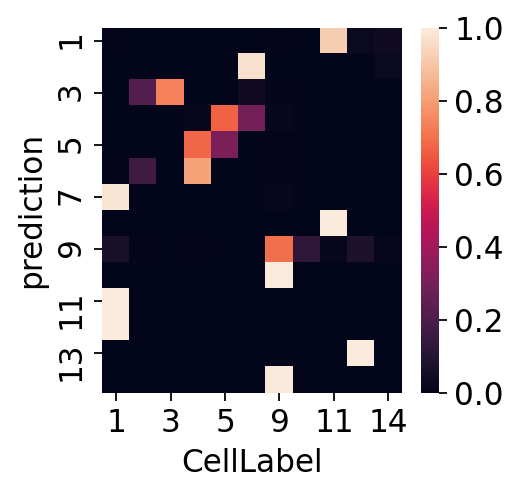

In [16]:
# r10
mlr = torch.load('MLR_NMF_r10.pt')
mlr.to(device)
print(val(mlr, device, data_loader, loss_fn))
v,p = torch.max(mlr(x_hum.to(device)),1)
hum_adata = sc.read_h5ad('../2/3 clustered_hum_0831_anno.h5ad')
hum_adata.obs['prediction'] = p.cpu().detach().numpy() + 1
hum_adata.obs = hum_adata.obs.astype({'prediction': 'category'})
hum_adata.obs['match'] = ((hum_adata.obs['prediction'].astype('int64') == hum_adata.obs['CellLabel'].astype('int64'))*1).astype('category')
sc.pl.tsne(hum_adata,color='prediction')
sc.pl.tsne(hum_adata,color='CellLabel')
sc.pl.tsne(hum_adata,color='match')

cmtx = sc.metrics.confusion_matrix("prediction", "CellLabel", hum_adata.obs)
sns.heatmap(cmtx)

/home/lh3n19/.conda/envs/my/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(24433.772184848785, 2557, 0.14155245094790922, array([0.01689189, 0.        , 0.78727915, 0.07535211, 0.00216216,
       0.        , 0.        , 0.        , 0.61914929, 0.        ,
       0.        , 0.        , 0.        , 0.        ]))


/home/lh3n19/.conda/envs/my/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


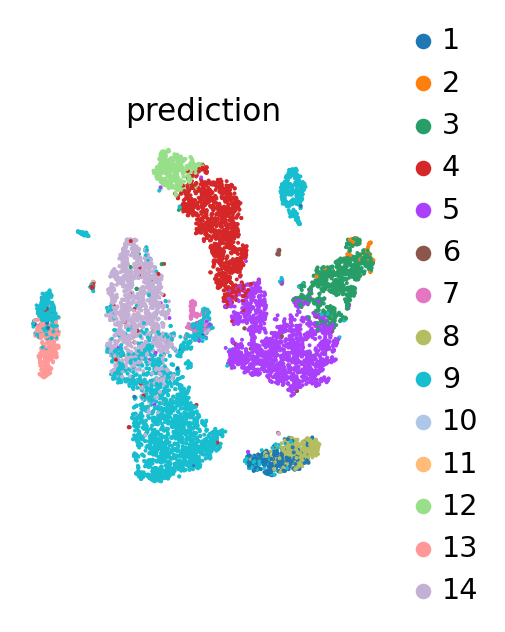

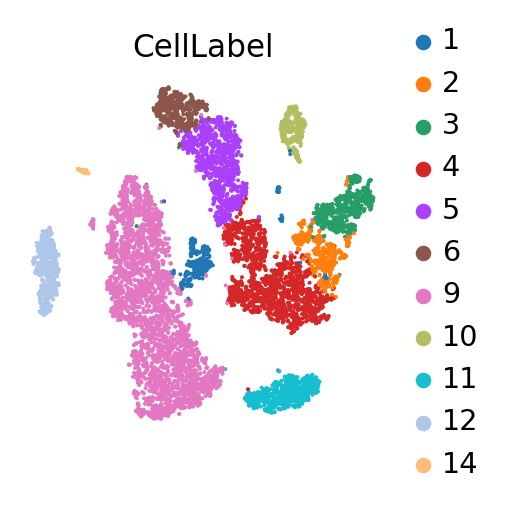

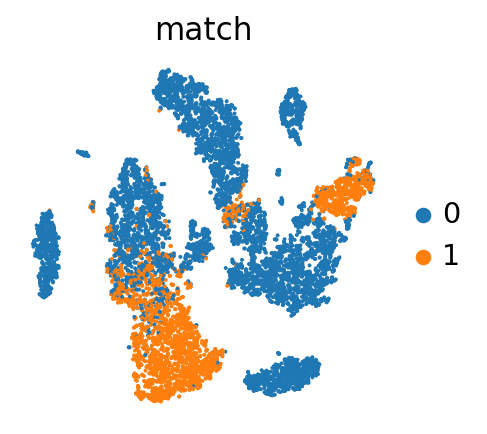

<AxesSubplot:xlabel='CellLabel', ylabel='prediction'>

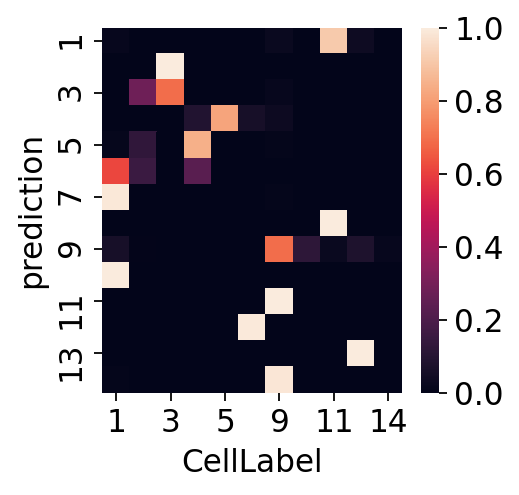

In [30]:
# r15
mlr = torch.load('MLR_NMF_r15.pt')
mlr.to(device)
print(val(mlr, device, data_loader, loss_fn))
v,p = torch.max(mlr(x_hum.to(device)),1)
hum_adata = sc.read_h5ad('../2/3 clustered_hum_0831_anno.h5ad')
hum_adata.obs['prediction'] = p.cpu().detach().numpy() + 1
hum_adata.obs = hum_adata.obs.astype({'prediction': 'category'})
hum_adata.obs['match'] = ((hum_adata.obs['prediction'].astype('int64') == hum_adata.obs['CellLabel'].astype('int64'))*1).astype('category')
sc.pl.tsne(hum_adata,color='prediction')
sc.pl.tsne(hum_adata,color='CellLabel')
sc.pl.tsne(hum_adata,color='match')

cmtx = sc.metrics.confusion_matrix("prediction", "CellLabel", hum_adata.obs)
sns.heatmap(cmtx)

/home/lh3n19/.conda/envs/my/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(24405.148286104202, 3371, 0.21180108027645755, array([2.97766749e-02, 1.92307692e-02, 8.09344386e-01, 1.11871467e-01,
       7.24637681e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.65069097e-01, 0.00000000e+00, 3.17460317e-03, 0.00000000e+00,
       0.00000000e+00, 1.32275132e-01]))


/home/lh3n19/.conda/envs/my/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


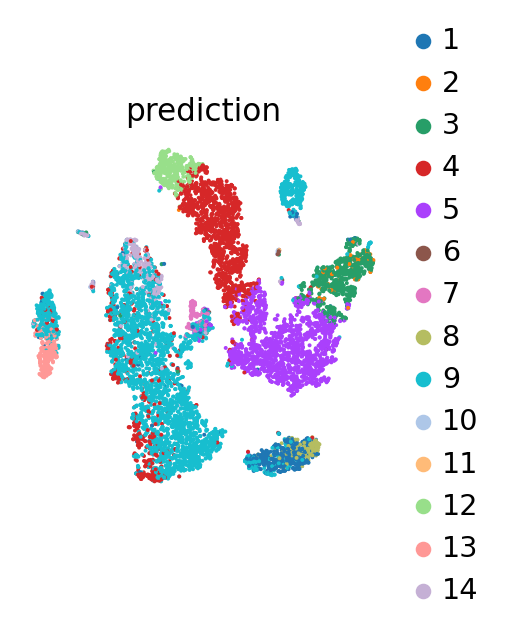

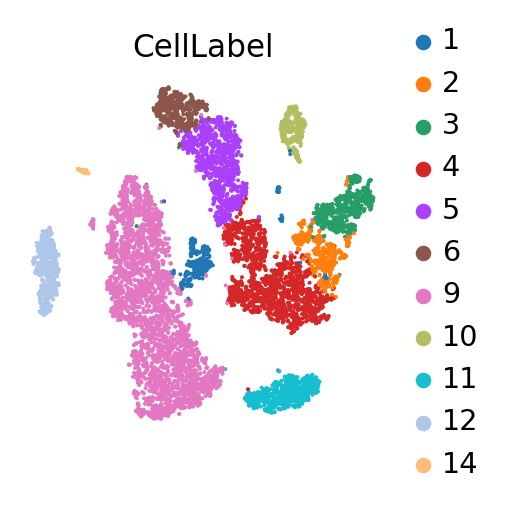

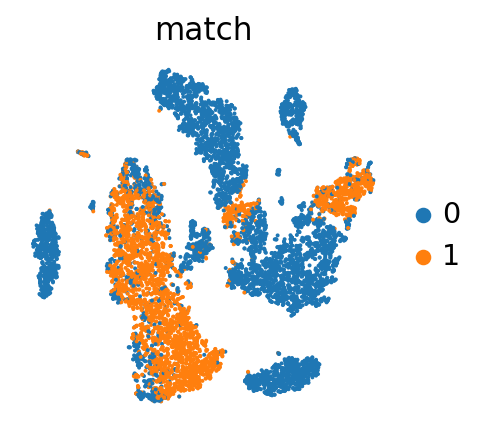

<AxesSubplot:xlabel='CellLabel', ylabel='prediction'>

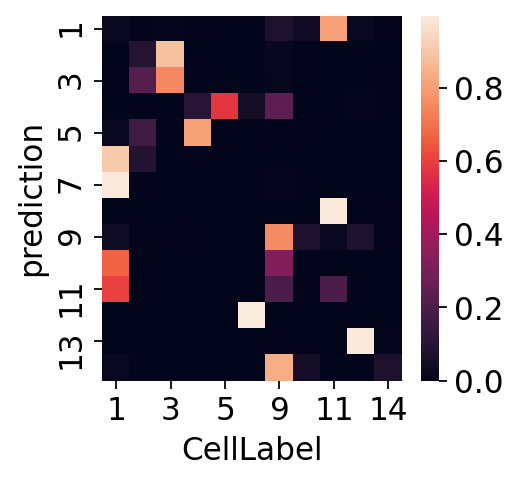

In [35]:
# r30
mlr = torch.load('MLR_NMF_r30.pt')
mlr.to(device)
print(val(mlr, device, data_loader, loss_fn))
v,p = torch.max(mlr(x_hum.to(device)),1)
hum_adata = sc.read_h5ad('../2/3 clustered_hum_0831_anno.h5ad')
hum_adata.obs['prediction'] = p.cpu().detach().numpy() + 1
hum_adata.obs = hum_adata.obs.astype({'prediction': 'category'})
hum_adata.obs['match'] = ((hum_adata.obs['prediction'].astype('int64') == hum_adata.obs['CellLabel'].astype('int64'))*1).astype('category')
sc.pl.tsne(hum_adata,color='prediction')
sc.pl.tsne(hum_adata,color='CellLabel')
sc.pl.tsne(hum_adata,color='match')

cmtx = sc.metrics.confusion_matrix("prediction", "CellLabel", hum_adata.obs)
sns.heatmap(cmtx)

/home/lh3n19/.conda/envs/my/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(24409.966459035873, 3032, 0.20928196762445958, array([0.0897561 , 0.06397306, 0.79341865, 0.07761194, 0.        ,
       0.        , 0.        , 0.        , 0.68437181, 0.01028278,
       0.        , 0.        , 0.        , 0.5       ]))


/home/lh3n19/.conda/envs/my/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


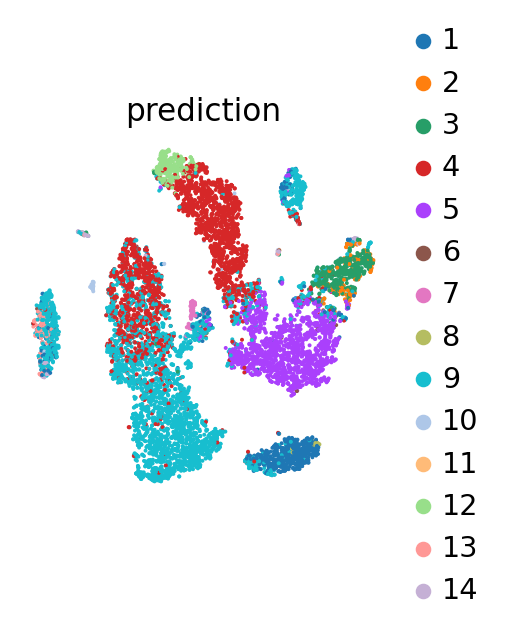

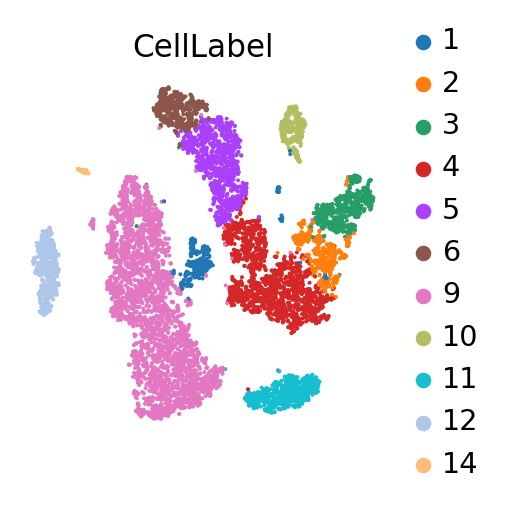

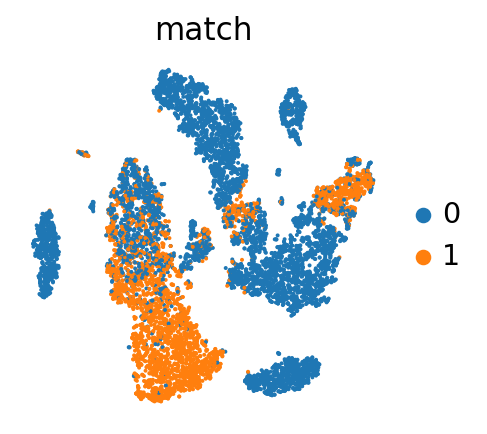

<AxesSubplot:xlabel='CellLabel', ylabel='prediction'>

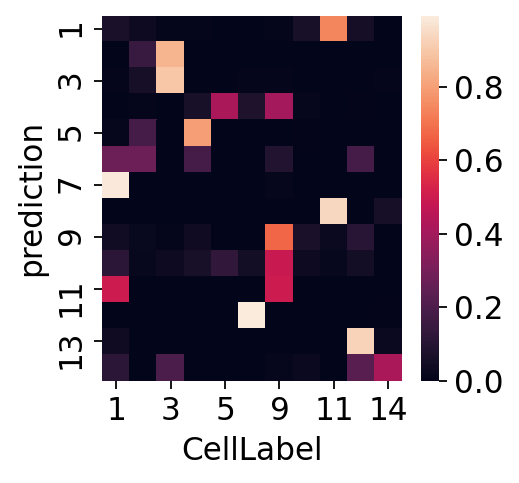

In [41]:
# r60
mlr = torch.load('MLR_NMF_r60.pt')
mlr.to(device)
print(val(mlr, device, data_loader, loss_fn))
v,p = torch.max(mlr(x_hum.to(device)),1)
hum_adata = sc.read_h5ad('../2/3 clustered_hum_0831_anno.h5ad')
hum_adata.obs['prediction'] = p.cpu().detach().numpy() + 1
hum_adata.obs = hum_adata.obs.astype({'prediction': 'category'})
hum_adata.obs['match'] = ((hum_adata.obs['prediction'].astype('int64') == hum_adata.obs['CellLabel'].astype('int64'))*1).astype('category')
sc.pl.tsne(hum_adata,color='prediction')
sc.pl.tsne(hum_adata,color='CellLabel')
sc.pl.tsne(hum_adata,color='match')

cmtx = sc.metrics.confusion_matrix("prediction", "CellLabel", hum_adata.obs)
sns.heatmap(cmtx)

# Retrained model

(20888.44109773636, 8643, 0.8809429597463873, array([0.77723577, 0.73788546, 0.89457364, 0.93575161, 0.83707597,
       0.69333333, 0.97955529, 0.94100719, 0.9678935 , 0.9879741 ,
       0.97916667]))


D:\Miniconda3\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


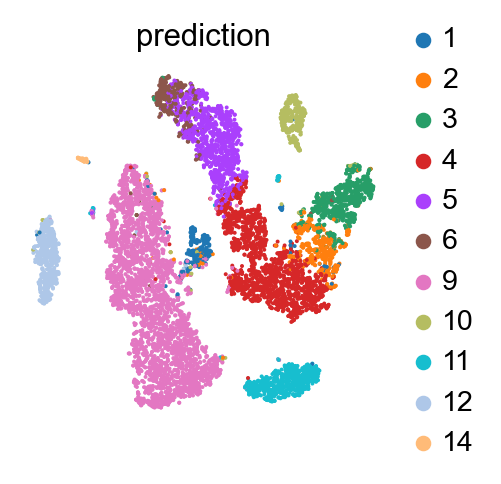

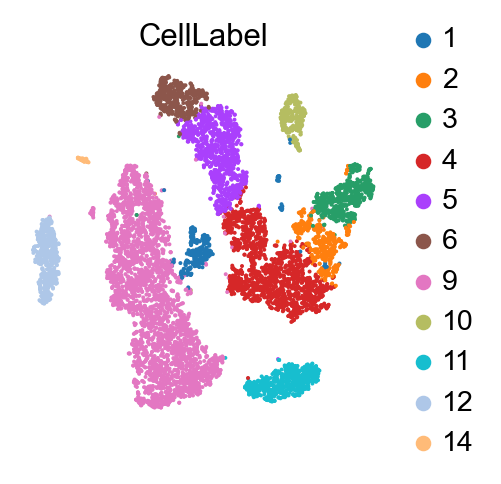

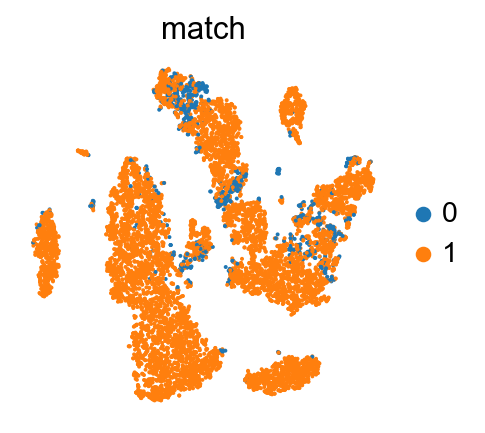

<AxesSubplot:xlabel='CellLabel', ylabel='prediction'>

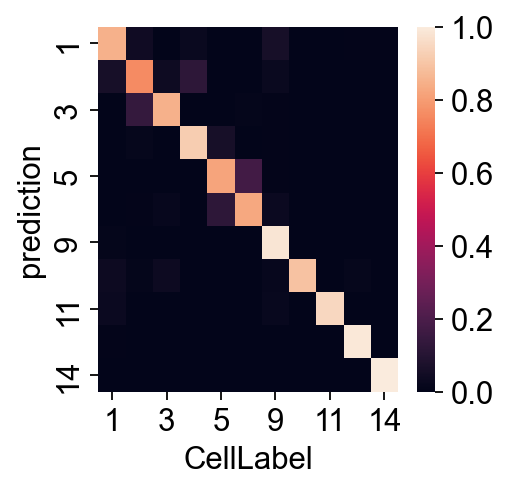

In [13]:
# r10
mlr = torch.load('MLR_NMF_r10_retrain.pt')
mlr.to(device)
print(val(mlr, device, data_loader, loss_fn))
v,p = torch.max(mlr(x_hum.to(device)),1)
hum_adata = sc.read_h5ad('../2/3 clustered_hum_0831_anno.h5ad')
hum_adata.obs['prediction'] = p.cpu().detach().numpy() + 1
hum_adata.obs = hum_adata.obs.astype({'prediction': 'category'})
hum_adata.obs['match'] = ((hum_adata.obs['prediction'].astype('int64') == hum_adata.obs['CellLabel'].astype('int64'))*1).astype('category')
sc.pl.tsne(hum_adata,color='prediction')
sc.pl.tsne(hum_adata,color='CellLabel')
sc.pl.tsne(hum_adata,color='match')

cmtx = sc.metrics.confusion_matrix("prediction", "CellLabel", hum_adata.obs)
sns.heatmap(cmtx)

(21038.90460062027, 8753, 0.9167339861698214, array([0.77291961, 0.74786325, 0.86546701, 0.93069307, 0.91997987,
       0.89880952, 0.97092404, 0.94614265, 0.97955975, 0.97748593,
       0.96      ]))


D:\Miniconda3\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


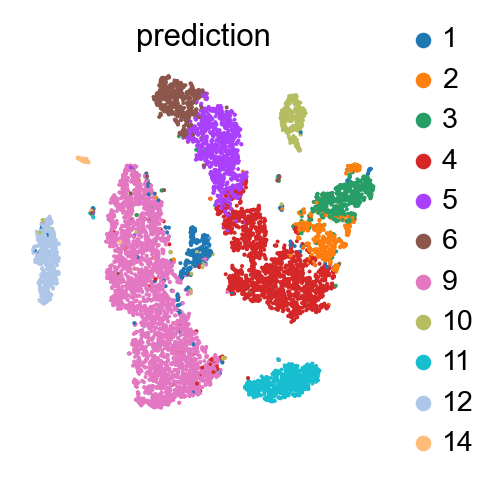

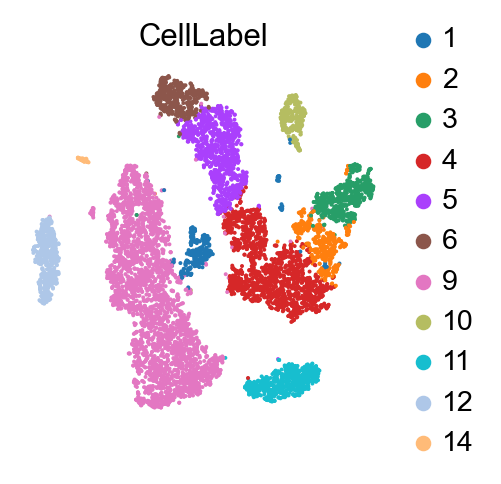

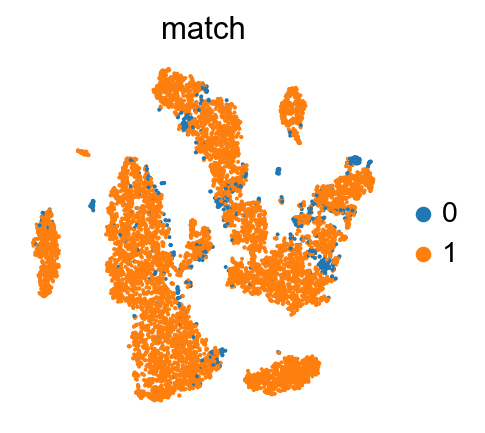

<AxesSubplot:xlabel='CellLabel', ylabel='prediction'>

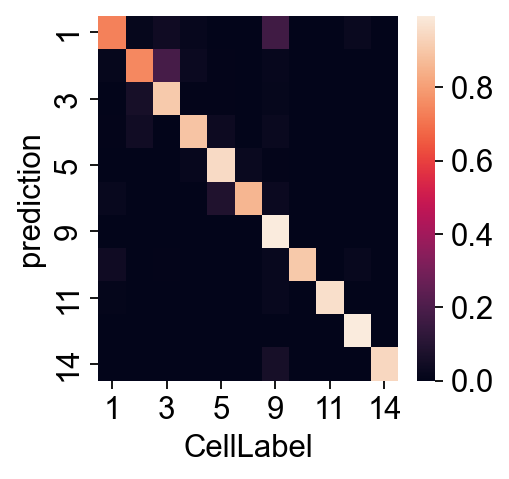

In [18]:
# r15
mlr = torch.load('MLR_NMF_r15_retrain.pt')
mlr.to(device)
print(val(mlr, device, data_loader, loss_fn))
v,p = torch.max(mlr(x_hum.to(device)),1)
hum_adata = sc.read_h5ad('../2/3 clustered_hum_0831_anno.h5ad')
hum_adata.obs['prediction'] = p.cpu().detach().numpy() + 1
hum_adata.obs = hum_adata.obs.astype({'prediction': 'category'})
hum_adata.obs['match'] = ((hum_adata.obs['prediction'].astype('int64') == hum_adata.obs['CellLabel'].astype('int64'))*1).astype('category')
sc.pl.tsne(hum_adata,color='prediction')
sc.pl.tsne(hum_adata,color='CellLabel')
sc.pl.tsne(hum_adata,color='match')

cmtx = sc.metrics.confusion_matrix("prediction", "CellLabel", hum_adata.obs)
sns.heatmap(cmtx)

(20837.614537239075, 8595, 0.8694004737119556, array([0.72959184, 0.73273273, 0.84691137, 0.93403531, 0.8649789 ,
       0.85558583, 0.97634473, 0.82260597, 0.95905512, 0.97312326,
       0.82352941]))


D:\Miniconda3\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


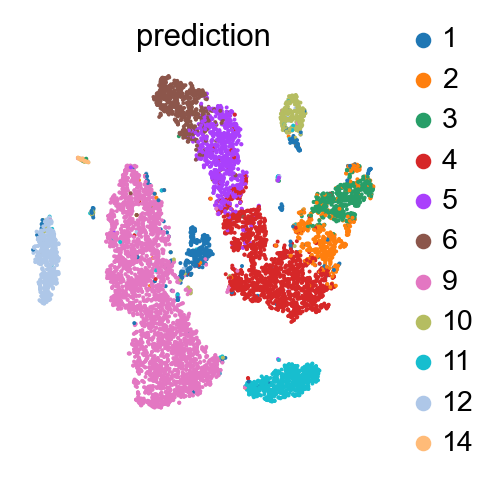

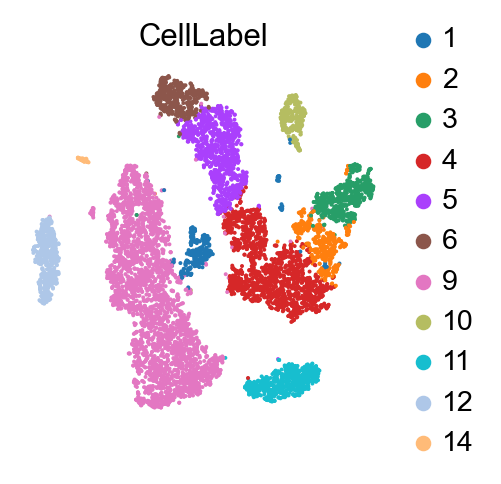

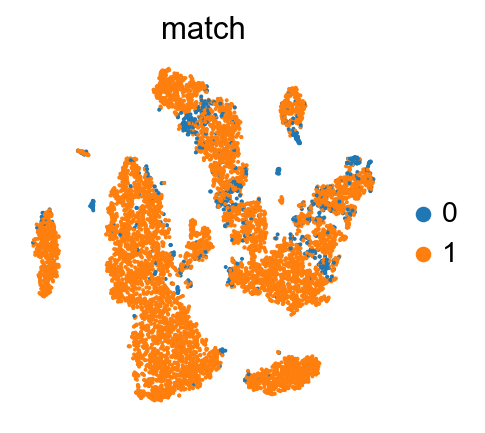

<AxesSubplot:xlabel='CellLabel', ylabel='prediction'>

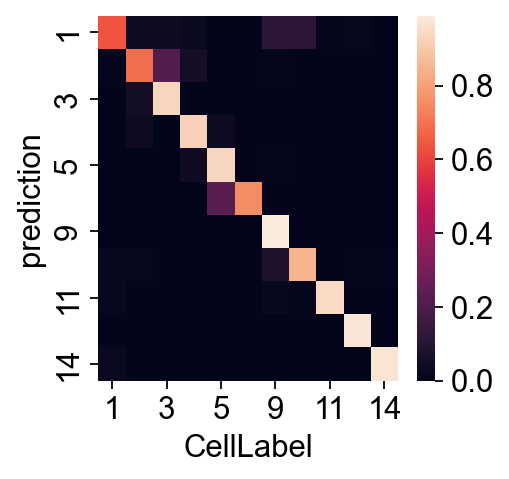

In [23]:
# r30
mlr = torch.load('MLR_NMF_r30_retrain.pt')
mlr.to(device)
print(val(mlr, device, data_loader, loss_fn))
v,p = torch.max(mlr(x_hum.to(device)),1)
hum_adata = sc.read_h5ad('../2/3 clustered_hum_0831_anno.h5ad')
hum_adata.obs['prediction'] = p.cpu().detach().numpy() + 1
hum_adata.obs = hum_adata.obs.astype({'prediction': 'category'})
hum_adata.obs['match'] = ((hum_adata.obs['prediction'].astype('int64') == hum_adata.obs['CellLabel'].astype('int64'))*1).astype('category')
sc.pl.tsne(hum_adata,color='prediction')
sc.pl.tsne(hum_adata,color='CellLabel')
sc.pl.tsne(hum_adata,color='match')

cmtx = sc.metrics.confusion_matrix("prediction", "CellLabel", hum_adata.obs)
sns.heatmap(cmtx)

(21077.245671987534, 8425, 0.8199878126822927, array([0.7642527 , 0.64774951, 0.86601597, 0.85817466, 0.83283454,
       0.82460137, 0.97620829, 0.91097923, 0.95810277, 0.96118299,
       0.57971014]))


D:\Miniconda3\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


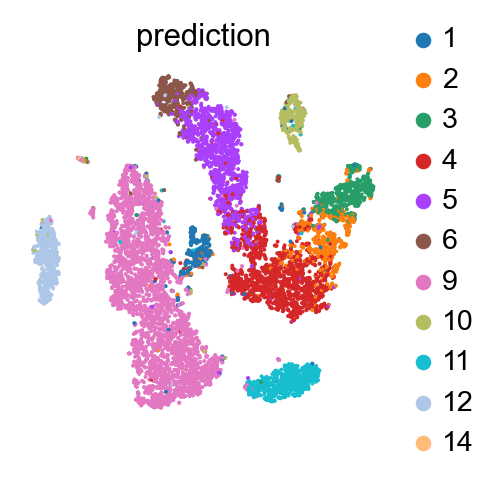

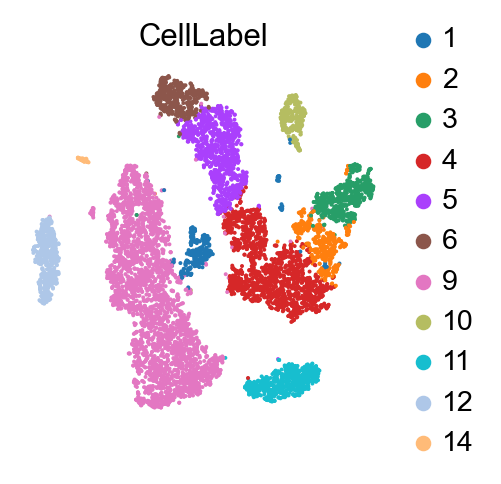

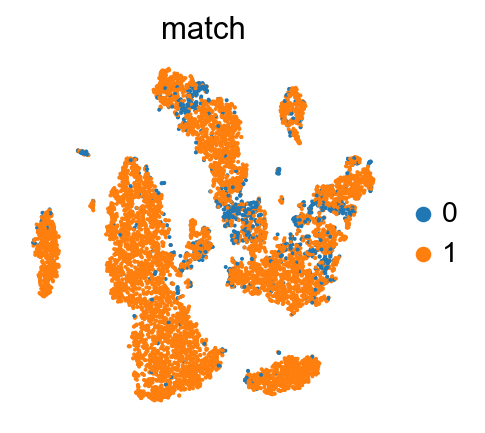

<AxesSubplot:xlabel='CellLabel', ylabel='prediction'>

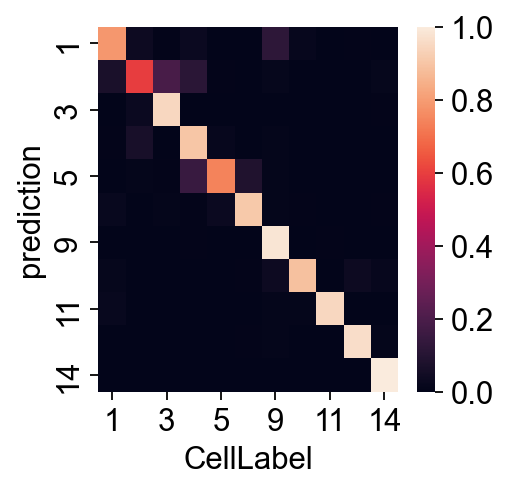

In [25]:
# r60
mlr = torch.load('MLR_NMF_r60_retrain.pt')
mlr.to(device)
print(val(mlr, device, data_loader, loss_fn))
v,p = torch.max(mlr(x_hum.to(device)),1)
hum_adata = sc.read_h5ad('../2/3 clustered_hum_0831_anno.h5ad')
hum_adata.obs['prediction'] = p.cpu().detach().numpy() + 1
hum_adata.obs = hum_adata.obs.astype({'prediction': 'category'})
hum_adata.obs['match'] = ((hum_adata.obs['prediction'].astype('int64') == hum_adata.obs['CellLabel'].astype('int64'))*1).astype('category')
sc.pl.tsne(hum_adata,color='prediction')
sc.pl.tsne(hum_adata,color='CellLabel')
sc.pl.tsne(hum_adata,color='match')

cmtx = sc.metrics.confusion_matrix("prediction", "CellLabel", hum_adata.obs)
sns.heatmap(cmtx)